In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats 
import scipy as sc
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import statsmodels.api
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn import metrics
import matplotlib.patches as mpatches

In [3]:
# “Blood genome expression profiles in infants with congenital cytomegalovirus infection.”
# Nature communications vol. 11,1 3548. 15 Jul. 2020,
# doi:10.1038/s41467-020-17178-5

data = pd.read_csv("GSE108211_series_matrix.csv", skiprows=64, index_col=[0])
data = data[:-1]

# get the classification vector for the data
y = pd.Series(pd.read_csv("GSE108211_series_matrix.csv", nrows=1, skiprows=42, header=None).T.iloc[1:, 0])
y = y.str.replace('group: ', '')

data = data.loc[:, y.values!='Control']
y = y[y.values!='Control']

Symptomatic     92
Asymptomatic    56


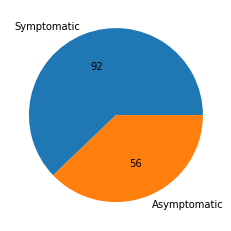

In [4]:
print(y.value_counts().to_string())
def absolute_value(val):
    a  = np.round(val/100.*y.value_counts().sum(), 0)
    return int(a)

y.value_counts().plot(kind='pie', subplots=True, autopct=absolute_value);
plt.ylabel('');

Deal with missing data

In [5]:
data = data.dropna()
print(data.shape[0])

47323


Pick 20 genes at random. Draw histograms comparing expression levels of each of these genes in the two classes M and H, we can see that the distributions are similar.

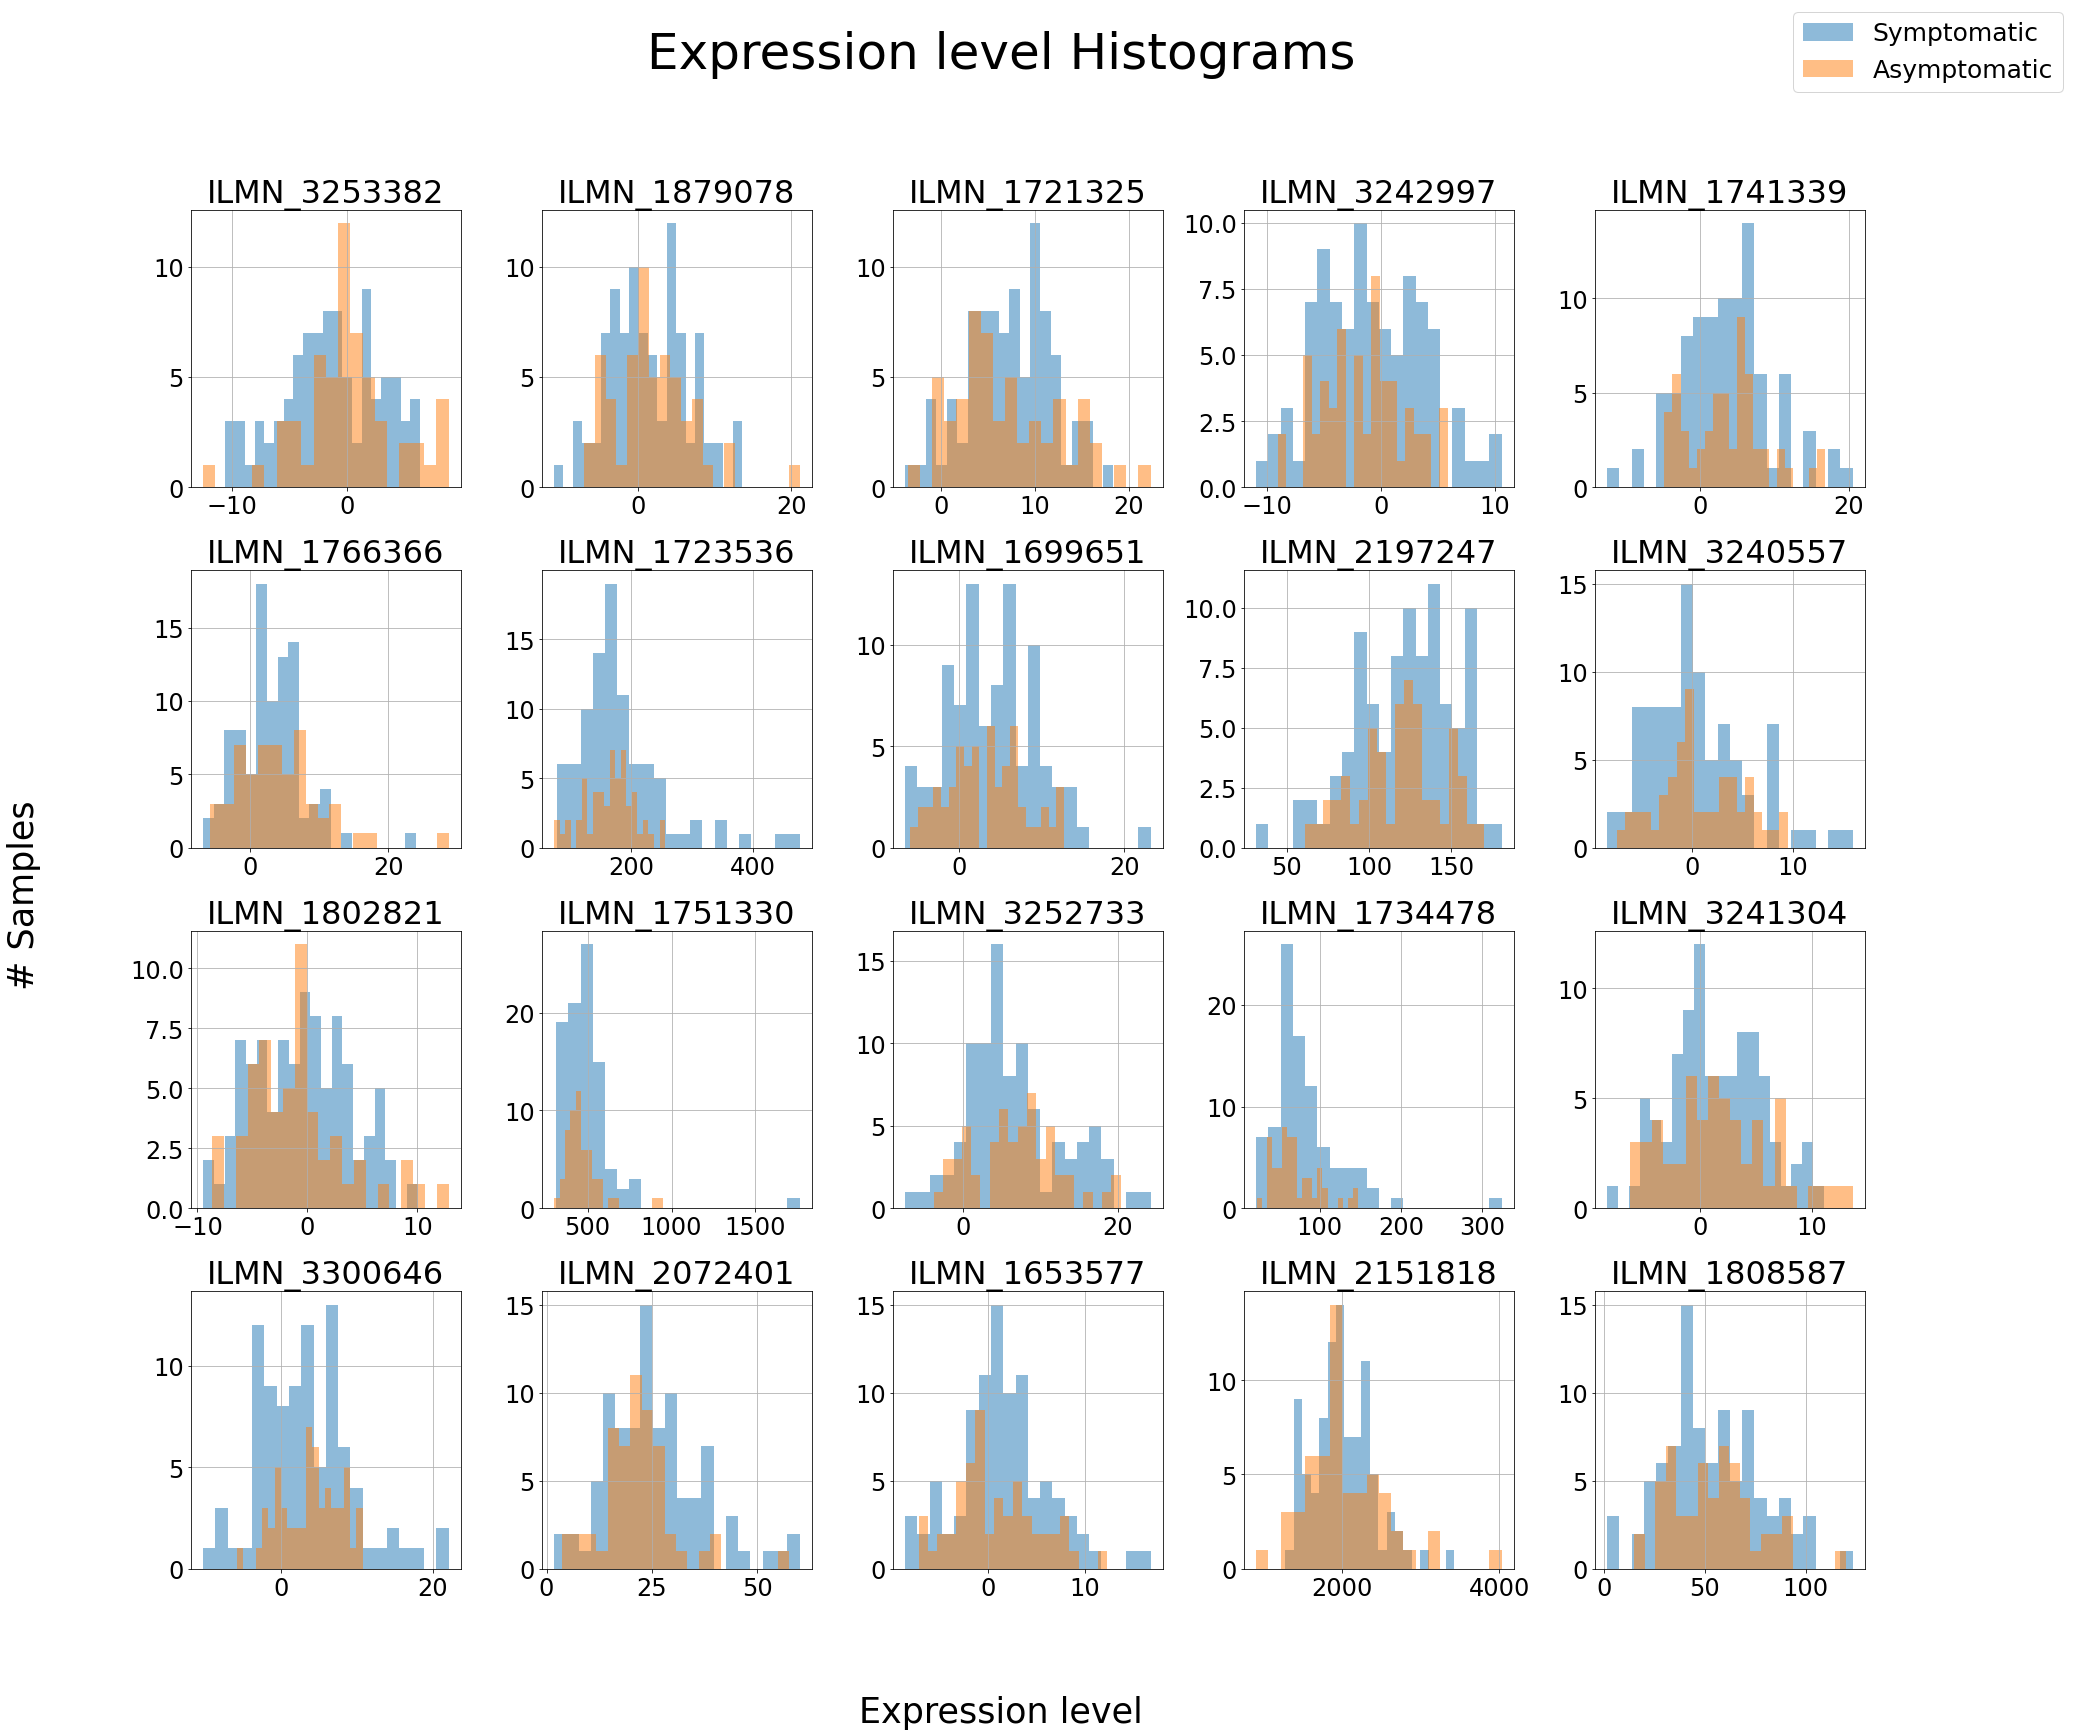

In [6]:
params = {'axes.titlesize':'32',
          'xtick.labelsize':'24',
          'ytick.labelsize':'24'}
plt.rcParams.update(params)

random_genes = data.sample(n=20, axis=0)
fig, graph_ax = plt.subplots(nrows=4, ncols=5, figsize=(30,25))
graph_ax = random_genes.loc[:, y.values == 'Symptomatic'].T.hist(ax=graph_ax, alpha = 0.5, bins=20)
random_genes.loc[:, y.values == 'Asymptomatic'].T.hist(ax=graph_ax, alpha = 0.5, bins=20);

# add - legends, axis names, general title 
fig.legend(labels = ['Symptomatic', 'Asymptomatic'], fontsize=25);  
fig.suptitle("Expression level Histograms", fontsize=50);

fig.text(0.5, 0.04, 'Expression level', ha='center', fontsize=35);
fig.text(0.04, 0.5, '# Samples', va='center', rotation='vertical', fontsize=35);


Split the dataset into a 80/20 train/test random split.

In [7]:
train, test, y_train, y_test= train_test_split(data.T, y, train_size=0.8, random_state=2021)
train, test = train.T, test.T

Select the 6 most significant DE genes from the training set according to WRS – best 3 overexpressed and best 3 underexpressed genes.

In [8]:
indH = y_train.values == 'Asymptomatic'
indM = y_train.values == 'Symptomatic'
WRS_down_reg = train.apply(lambda x: scipy.stats.mannwhitneyu(x[indH], x[indM], alternative='less')[1], axis=1)  # WRS one sided less
WRS_up_reg = train.apply(lambda x: scipy.stats.mannwhitneyu(x[indH], x[indM], alternative='greater')[1], axis=1)  # WRS one sided greater

In [9]:
names = WRS_down_reg.sort_values()[:3].index.tolist() + (WRS_up_reg.sort_values()[:3]).index.tolist()
signif_WRS_genes = train.loc[names, ] 

Perform Naïve Bayes classification to predict the classes M and H

In [10]:
signif_WRS_genes.head()

,GSM2892403,GSM2892465,GSM2892391,GSM2892410,GSM2892452,GSM2892360,GSM2892378,GSM2892381,GSM2892400,GSM2892481,...,GSM2892437,GSM2892357,GSM2892406,GSM2892380,GSM2892438,GSM2892453,GSM2892472,GSM2892401,GSM2892429,GSM2892460
ID_REF,,,,,,,,,,,,,,,,,,,,,
ILMN_1831421,7.0898,-0.7552,10.6418,7.3341,12.7504,0.8440,4.6072,3.5063,18.3178,10.9063,...,1.1104,-0.6291,7.3688,11.2885,13.4939,7.7582,9.8397,6.6214,8.1505,5.4771
ILMN_1725791,23.5382,20.3921,33.2938,36.8502,12.9288,10.4221,6.9415,26.2291,19.7032,16.9274,...,25.9045,21.1159,22.4103,8.9302,27.8278,29.7299,19.0202,21.0273,49.5133,20.5437
ILMN_3246424,70.3668,52.5754,44.6110,31.3070,63.5767,30.6943,47.7504,44.6187,49.2947,48.8488,...,60.9122,40.4253,55.6371,38.0208,63.4933,33.3273,39.2948,42.6147,68.4713,39.3689
ILMN_1666845,2.6866,-1.1754,11.7715,-2.1262,24.3175,1.3880,2.6686,13.7853,5.0438,6.4915,...,-1.0841,-0.9909,4.3960,0.4302,3.1752,-2.9042,-0.8392,-0.1278,1.3298,-1.8902
ILMN_1759297,14.5448,10.0009,9.0850,2.2402,12.4378,5.7626,22.9397,6.9494,-1.6479,4.0608,...,-5.2381,11.9686,0.0098,7.3109,-2.8300,-0.2416,6.9734,2.1555,6.8120,-2.0251


In [11]:
model = GaussianNB()
model.fit(signif_WRS_genes.T, y_train.values)
y_pred = model.predict(test.loc[names, ].T)
print('accuracy', sum(y_pred == y_test)/len(y_pred))
precision, recall, fscore, support = score(y_test, y_pred, average='binary', pos_label='Symptomatic')
print('precision, recall, fscore:', precision, recall, fscore)

accuracy 0.5666666666666667
precision, recall, fscore: 0.6 0.7058823529411765 0.6486486486486486


Build a Decision Tree to predict the the classes M and H

In [12]:
tree_model = DecisionTreeClassifier()
tree_model.fit(signif_WRS_genes.T, y_train.values)
y_pred_tree = tree_model.predict(test.loc[names, ].T)
print('accuracy', sum(y_pred_tree == y_test)/len(y_pred))
precision, recall, fscore, support = score(y_test, y_pred_tree, average='binary', pos_label='Symptomatic')
print('precision, recall, fscore:', precision, recall, fscore)

accuracy 0.5666666666666667
precision, recall, fscore: 0.6 0.7058823529411765 0.6486486486486486


Logistic regression

accuracy 0.6
precision, recall, fscore: 0.6190476190476191 0.7647058823529411 0.6842105263157895


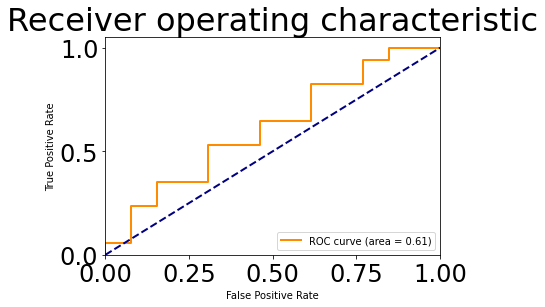

In [13]:
logreg_model = LogisticRegression()
logreg_model.fit(signif_WRS_genes.T, y_train.values)  # (y_train.values == 'Symptomatic').astype(int)
y_pred_logreg = logreg_model.predict(test.loc[names, ].T)
y_score = logreg_model.decision_function(test.loc[names, ].T)
print('accuracy', sum(y_pred_logreg == y_test)/len(y_pred_logreg))
precision, recall, fscore, support = score(y_test, y_pred_logreg, average='binary', pos_label='Symptomatic')
print('precision, recall, fscore:', precision, recall, fscore)
fpr, tpr, _ = metrics.roc_curve(y_test, y_score, pos_label = 'Symptomatic')
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

SVM

In [14]:
svm_model = svm.SVC()
svm_model.fit(signif_WRS_genes.T, y_train.values)
y_pred_svm = svm_model.predict(test.loc[names, ].T)
print('accuracy', sum(y_pred_svm == y_test)/len(y_test))
precision, recall, fscore, support = score(y_test, y_pred_svm, average='binary', pos_label='Symptomatic')
print('precision, recall, fscore:', precision, recall, fscore)

accuracy 0.5666666666666667
precision, recall, fscore: 0.5909090909090909 0.7647058823529411 0.6666666666666667
